# Figure 5: Regional-average SST-index Skill (correlation & RMSE)

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

## Start Dask Cluster

In [1]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='P93300313',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks':True
    })
    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(30)

/glade/u/home/tking/anaconda3/envs/esp-lab/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33095 instead
  warnings.warn(


In [4]:
cluster

# Data Intake

### Read in SMYLE monthly SST data using I/O functions; Convert to seasonal mean

In [5]:
# This preprocessor will return POP SST (first vertical grid level only)
def preprocessor(d0, nlead, field):
    """ This preprocessor is applied on an individual timeseries file basis.
    Edit this appropriately for your analysis to speed up processing.

    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0, 'time')
    d0 = d0.isel(z_t=0).isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field, 'time', 'TLAT', 'TLONG', 'TAREA']].drop(['ULAT', 'ULONG'])
    d0 = d0.chunk({'L': -1})
    return d0

In [6]:
%%time
# SMYLE-Nov SST data
# process all 20 ensemble members, all November start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 11
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle11.nbytes/1e9 #GB

CPU times: user 22.7 s, sys: 11.3 s, total: 34 s
Wall time: 1min 32s


11.563509676

In [7]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()

CPU times: user 12.7 s, sys: 196 ms, total: 12.9 s
Wall time: 15.2 s


In [8]:
%%time
# SMYLE-Feb SST data
# process all 20 ensemble members, all February start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 2
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle02.nbytes/1e9 #GB

CPU times: user 52.3 s, sys: 12.2 s, total: 1min 4s
Wall time: 1min 47s


11.563509676

In [9]:
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()

In [10]:
%%time
# SMYLE-May SST data
# process all 20 ensemble members, all May start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 5
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle05.nbytes/1e9 #GB

CPU times: user 53.8 s, sys: 12.1 s, total: 1min 5s
Wall time: 1min 50s


11.563509676

In [11]:
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()

In [12]:
%%time
# SMYLE-Aug SST data
# process all 20 ensemble members, all August start dates from 1970-2018:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
firstyear = 1970
lastyear  = 2018
startyears = list(range(firstyear, lastyear+1))
startmonth = 8
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,startyears,startmonth,preprocessor)
smyle08.nbytes/1e9 #GB

CPU times: user 56.5 s, sys: 12.1 s, total: 1min 8s
Wall time: 1min 53s


11.563509676

In [13]:
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()

# Compute Regional-average SST

### Define Averaging Regions

In [14]:
# lon-w, lon-e, lat-s, lat-n:
# region1lonlat = [-170.,-120.,-5.,5.]
# region1title = 'Nino3.4'

region1lonlat = [-20., 0., -3., 3.]
region1title = 'Atlantic Nino'

region2lonlat = [-80., -10., 10., 20.]
region2title = 'Atlantic MDR'

region3lonlat = [50., 70., -10., 10.]  # IOD-west, to be overwritten by IOD
region3title = 'Indian Ocean Dipole'

region4lonlat = [90., 110., -10., 0.]  # IOD-east
region4title = 'IODe'

In [15]:
def POP_regional_areawgt(ds, lonlat):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG > 180., ds.TLONG - 360., ds.TLONG)
    region = (tlat >= lonlat[2]) & (tlat <= lonlat[3]) & (tlon >= lonlat[0]) & (tlon <= lonlat[1])
    return xr.where(region, tarea.fillna(0), 0)

In [16]:
POPg16_reg1sst_area = POP_regional_areawgt(smyle11, region1lonlat)
POPg16_reg2sst_area = POP_regional_areawgt(smyle11, region2lonlat)
POPg16_reg3sst_area = POP_regional_areawgt(smyle11, region3lonlat)
POPg16_reg4sst_area = POP_regional_areawgt(smyle11, region4lonlat)

### Perform computation on SMYLE dask arrays, returning xarray:

In [17]:
%%time
smyle11_seas_time = smyle11_seas.time.load()
smyle02_seas_time = smyle02_seas.time.load()
smyle05_seas_time = smyle05_seas.time.load()
smyle08_seas_time = smyle08_seas.time.load()

CPU times: user 11.1 s, sys: 243 ms, total: 11.3 s
Wall time: 12 s


In [18]:
%%time
smyle11_seas_reg1sst = smyle11_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg1sst = smyle02_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg1sst = smyle05_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg1sst = smyle08_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 15s, sys: 1.98 s, total: 2min 17s
Wall time: 2min 51s


In [19]:
%%time
smyle11_seas_reg2sst = smyle11_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg2sst = smyle02_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg2sst = smyle05_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg2sst = smyle08_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()

CPU times: user 1min 46s, sys: 1.15 s, total: 1min 47s
Wall time: 1min 54s


In [20]:
%%time
smyle11_seas_reg3sst = smyle11_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg3sst = smyle02_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg3sst = smyle05_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg3sst = smyle08_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()

CPU times: user 1min 49s, sys: 1.14 s, total: 1min 51s
Wall time: 1min 58s


In [21]:
%%time
smyle11_seas_reg4sst = smyle11_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg4sst = smyle02_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg4sst = smyle05_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg4sst = smyle08_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()

CPU times: user 1min 50s, sys: 1.18 s, total: 1min 51s
Wall time: 1min 59s


In [22]:
%%time
smyle11_seas_reg3sst = smyle11_seas_reg3sst - smyle11_seas_reg4sst
smyle02_seas_reg3sst = smyle02_seas_reg3sst - smyle02_seas_reg4sst
smyle05_seas_reg3sst = smyle05_seas_reg3sst - smyle05_seas_reg4sst
smyle08_seas_reg3sst = smyle08_seas_reg3sst - smyle08_seas_reg4sst

CPU times: user 3.12 ms, sys: 0 ns, total: 3.12 ms
Wall time: 3.12 ms


### Remove leadtime-dependent drift from SMYLE data:

In [23]:
%%time
climy0 = 1972
climy1 = 2018
smyle11_reg1sst_dd,smyle11_reg1sst_drift = stats.remove_drift(smyle11_seas_reg1sst,smyle11_seas_time,climy0,climy1)
smyle02_reg1sst_dd,smyle02_reg1sst_drift = stats.remove_drift(smyle02_seas_reg1sst,smyle02_seas_time,climy0,climy1)
smyle05_reg1sst_dd,smyle05_reg1sst_drift = stats.remove_drift(smyle05_seas_reg1sst,smyle05_seas_time,climy0,climy1)
smyle08_reg1sst_dd,smyle08_reg1sst_drift = stats.remove_drift(smyle08_seas_reg1sst,smyle08_seas_time,climy0,climy1)

smyle11_reg2sst_dd,smyle11_reg2sst_drift = stats.remove_drift(smyle11_seas_reg2sst,smyle11_seas_time,climy0,climy1)
smyle02_reg2sst_dd,smyle02_reg2sst_drift = stats.remove_drift(smyle02_seas_reg2sst,smyle02_seas_time,climy0,climy1)
smyle05_reg2sst_dd,smyle05_reg2sst_drift = stats.remove_drift(smyle05_seas_reg2sst,smyle05_seas_time,climy0,climy1)
smyle08_reg2sst_dd,smyle08_reg2sst_drift = stats.remove_drift(smyle08_seas_reg2sst,smyle08_seas_time,climy0,climy1)

smyle11_reg3sst_dd,smyle11_reg3sst_drift = stats.remove_drift(smyle11_seas_reg3sst,smyle11_seas_time,climy0,climy1)
smyle02_reg3sst_dd,smyle02_reg3sst_drift = stats.remove_drift(smyle02_seas_reg3sst,smyle02_seas_time,climy0,climy1)
smyle05_reg3sst_dd,smyle05_reg3sst_drift = stats.remove_drift(smyle05_seas_reg3sst,smyle05_seas_time,climy0,climy1)
smyle08_reg3sst_dd,smyle08_reg3sst_drift = stats.remove_drift(smyle08_seas_reg3sst,smyle08_seas_time,climy0,climy1)

CPU times: user 65.6 ms, sys: 0 ns, total: 65.6 ms
Wall time: 95.4 ms


### Compute observed seasonal anomalies:

In [24]:
def obs_convert_mon_to_seas(da, field):
    """ Given a monthly xarray DataArray, convert to
    seasonal averages and replace 'time' with 'year,season' dimensions."""
    season = xr.DataArray(['DJF', 'MAM', 'JJA', 'SON'], dims='season', name='season')
    da_group = cal.mon_to_seas(da).groupby('time.month')
    xrlist = []
    for i in [1, 4, 7, 10]:
        tmp = da_group[i]
        tmp = tmp.assign_coords(year=("time", np.unique(tmp.time.dt.year.values)))
        tmp = tmp.swap_dims({"time": "year"}).to_dataset(name=field)
        tmp = tmp.reset_coords(["time"])
        tmp["time"] = tmp.time.expand_dims("season")
        xrlist.append(tmp)
    da_seas = xr.concat(xrlist, dim=season)
    return da_seas

In [25]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_obs = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_obs.time)
obs_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_obs['time'] = obs_montime_vals
ds_obs['sst'] = xr.where(ds_obs['sst'] < -2, -1.8, ds_obs['sst'])
ds_obs = ds_obs.sel(time=slice("1960","2020"))

In [26]:
# Note that latitude decreases with index in this dataset!
ds_obs = ds_obs.rename({"latitude": "lat", "longitude": "lon"})

In [27]:
# Region 1
tmp = ds_obs.sst.sel(lat=slice(region1lonlat[3], region1lonlat[2])).sel(lon=slice(region1lonlat[0], region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg1sst_seas = obs_convert_mon_to_seas(obs_regsst, 'sst')
obs_reg1sst_seas = obs_reg1sst_seas - obs_reg1sst_seas.sel(year=slice(climy0, climy1)).mean('year')

In [28]:
# Region 2
tmp = ds_obs.sst.sel(lat=slice(region2lonlat[3], region2lonlat[2])).sel(lon=slice(region2lonlat[0], region2lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg2sst_seas = obs_convert_mon_to_seas(obs_regsst, 'sst')
obs_reg2sst_seas = obs_reg2sst_seas - obs_reg2sst_seas.sel(year=slice(climy0, climy1)).mean('year')

In [29]:
# Region 3
tmp = ds_obs.sst.sel(lat=slice(region3lonlat[3], region3lonlat[2])).sel(lon=slice(region3lonlat[0], region3lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg3sst_seas = obs_convert_mon_to_seas(obs_regsst, 'sst')

tmp = ds_obs.sst.sel(lat=slice(region4lonlat[3], region4lonlat[2])).sel(lon=slice(region4lonlat[0], region4lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_regsst = tmp.weighted(wgts).mean(("lon", "lat")).load()
obs_reg4sst_seas = obs_convert_mon_to_seas(obs_regsst, 'sst')

obs_reg3sst_seas = obs_reg3sst_seas - obs_reg4sst_seas
obs_reg3sst_seas = obs_reg3sst_seas - obs_reg3sst_seas.sel(year=slice(climy0, climy1)).mean('year')

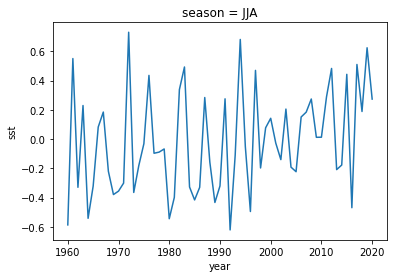

In [30]:
obs_reg3sst_seas.sst.isel(season=2).plot();

# Plots

### Generate ACC and normalized RMSE Skill Plot

In [31]:
%%time
# Correlation as a function of forecast lead month:
smyle11_skill_reg1 = stats.leadtime_skill_seas(smyle11_reg1sst_dd,smyle11_seas_time,obs_reg1sst_seas.sst,detrend=True)
smyle02_skill_reg1 = stats.leadtime_skill_seas(smyle02_reg1sst_dd,smyle02_seas_time,obs_reg1sst_seas.sst,detrend=True)
smyle05_skill_reg1 = stats.leadtime_skill_seas(smyle05_reg1sst_dd,smyle05_seas_time,obs_reg1sst_seas.sst,detrend=True)
smyle08_skill_reg1 = stats.leadtime_skill_seas(smyle08_reg1sst_dd,smyle08_seas_time,obs_reg1sst_seas.sst,detrend=True)

smyle11_skill_reg2 = stats.leadtime_skill_seas(smyle11_reg2sst_dd,smyle11_seas_time,obs_reg2sst_seas.sst,detrend=True)
smyle02_skill_reg2 = stats.leadtime_skill_seas(smyle02_reg2sst_dd,smyle02_seas_time,obs_reg2sst_seas.sst,detrend=True)
smyle05_skill_reg2 = stats.leadtime_skill_seas(smyle05_reg2sst_dd,smyle05_seas_time,obs_reg2sst_seas.sst,detrend=True)
smyle08_skill_reg2 = stats.leadtime_skill_seas(smyle08_reg2sst_dd,smyle08_seas_time,obs_reg2sst_seas.sst,detrend=True)

smyle11_skill_reg3 = stats.leadtime_skill_seas(smyle11_reg3sst_dd,smyle11_seas_time,obs_reg3sst_seas.sst,detrend=True)
smyle02_skill_reg3 = stats.leadtime_skill_seas(smyle02_reg3sst_dd,smyle02_seas_time,obs_reg3sst_seas.sst,detrend=True)
smyle05_skill_reg3 = stats.leadtime_skill_seas(smyle05_reg3sst_dd,smyle05_seas_time,obs_reg3sst_seas.sst,detrend=True)
smyle08_skill_reg3 = stats.leadtime_skill_seas(smyle08_reg3sst_dd,smyle08_seas_time,obs_reg3sst_seas.sst,detrend=True)


CPU times: user 1.72 s, sys: 6.75 ms, total: 1.73 s
Wall time: 1.97 s


In [32]:
# combine skill score xarrays for plotting
startmonth = xr.DataArray([11, 2, 5, 8], name='startmonth', dims='startmonth')
region = xr.DataArray([1, 2, 3], name='region', dims='region')
reg1_skill = xr.concat([smyle11_skill_reg1, smyle02_skill_reg1, smyle05_skill_reg1, smyle08_skill_reg1], dim=startmonth)
reg2_skill = xr.concat([smyle11_skill_reg2, smyle02_skill_reg2, smyle05_skill_reg2, smyle08_skill_reg2], dim=startmonth)
reg3_skill = xr.concat([smyle11_skill_reg3, smyle02_skill_reg3, smyle05_skill_reg3, smyle08_skill_reg3], dim=startmonth)
reg_skill = xr.concat([reg1_skill, reg2_skill, reg3_skill], dim=region)
regiontitle = xr.DataArray([region1title, region2title, region3title], name='regiontitle', dims='region')
reg_skill['regiontitle'] = regiontitle

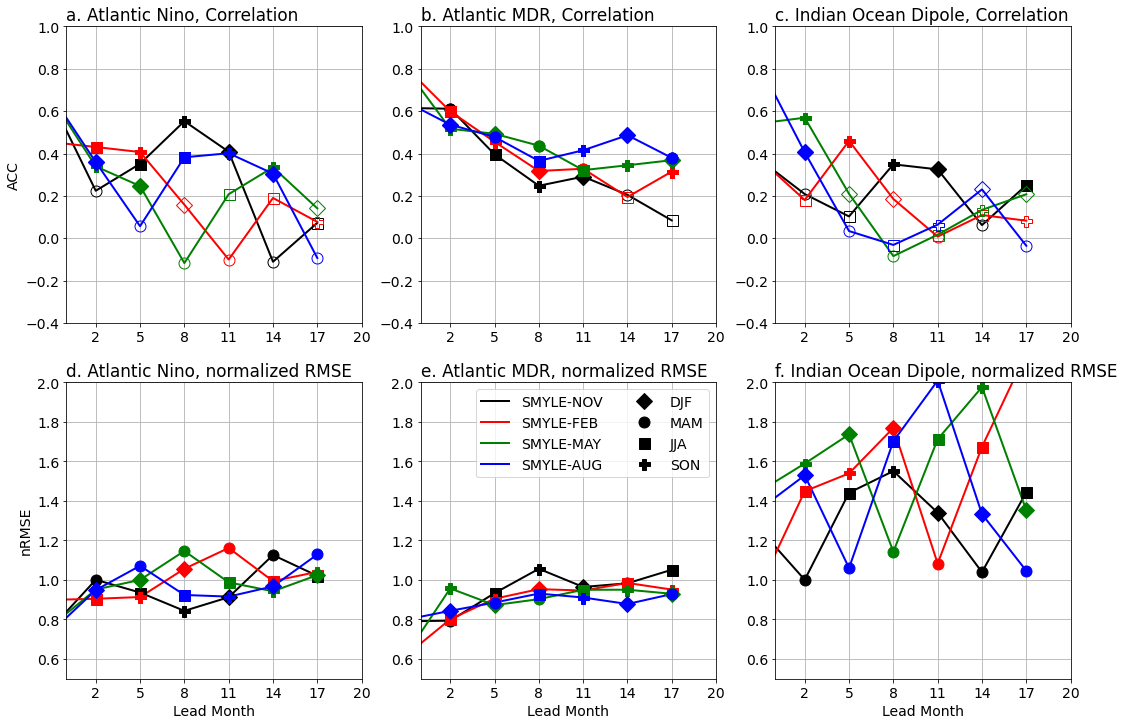

In [33]:
# plot skill scores
fig = plt.figure(figsize=(18, 12))
plt.rcParams['font.size'] = '14'
leadmon = smyle11_skill_reg1.L-2
seasons = ['DJF', 'MAM', 'JJA', 'SON']
markers = ['D', 'o', 's', 'P']
colors = ['k', 'r', 'g', 'b']
hindcasts = ['NOV', 'FEB', 'MAY', 'AUG']
figlabs = [['a.', 'b.', 'c.'], ['d.', 'e.', 'f.']]

ncol = 3
nrow = 2

for i in range(ncol):
    ax = fig.add_subplot(nrow, ncol, i+1)
    if i == 0:
        ax.set_ylabel('ACC', fontsize=14)
    ax.set_title(figlabs[0][i]+' {}, Correlation'.format(reg_skill.isel(region=i).regiontitle.values),loc='left')
    for j in range(4):
        ax.plot(leadmon, reg_skill.isel(region=i, startmonth=j).corr, color=colors[j], linewidth=2, label='SMYLE-' + hindcasts[j])
        for k, l in zip(seasons, markers):
            tmp = reg_skill.isel(region=i, startmonth=j)
            ax.plot(leadmon, tmp.corr.where(tmp.season == k), color=colors[j], marker=l, markersize=11, fillstyle='none')
            ax.plot(leadmon, tmp.corr.where(tmp.season == k).where(tmp.pval < 0.1), color=colors[j], marker=l, markersize=11)

    ax.set_xticks(leadmon)
    ax.grid(True)
    ax.set_xlim([0, 20])
    ax.set_ylim([-0.4, 1])

    ax = fig.add_subplot(nrow, ncol, i+4)
    if i == 0:
        ax.set_ylabel(r'nRMSE', fontsize=14)
    ax.set_title(figlabs[1][i]+' {}, normalized RMSE'.format(reg_skill.isel(region=i).regiontitle.values), loc='left')
    for j in range(4):
        ax.plot(leadmon, reg_skill.isel(region=i, startmonth=j).nrmse, color=colors[j], linewidth=2, label='SMYLE-' + hindcasts[j])
    for j in range(4):
        for k, l in zip(seasons, markers):
            tmp = reg_skill.isel(region=i, startmonth=j)
            if j == 0:
                ax.plot(leadmon, tmp.nrmse.where(tmp.season==k), color=colors[j], marker=l, label=k, markersize=11, linestyle='None')
            if j != 0:
                ax.plot(leadmon, tmp.nrmse.where(tmp.season==k), color=colors[j], marker=l, markersize=11)
    if i==1:
        leg1 = ax.legend(loc='upper right', ncol=2)
    ax.set_xticks(leadmon)
    ax.set_xlabel('Lead Month')
    ax.grid(True)
    ax.set_xlim([0, 20])
    ax.set_ylim([0.5, 2])

# plt.savefig('Fig05_regionalSST_skill.png')